In [1]:
import math
import numpy as np
import scipy.integrate as integrate   # для решения ОДУ в методе DEM
import matplotlib.pyplot as plt
from time import time

# Hashin–Shtrikman bounds (HS)

In [2]:
# HS - bulk модуль - 2 компоненты (prop - в процентах)
def get_HS_bulk_bounds(bulk, shear, prop):
    # функция возвращает верхнюю и нижнюю границы HS для объемного модуля сжатия (bulk) композита,
    # состоящего из двух компонент

    # входные данные
    k1, k2 = bulk        # объемные модули сжатия (bulk) 1ой и 2ой компонент
    g1, g2 = shear       # модули сдвига (shear) 1ой и 2ой компонент
    f1 = prop / 100       # объмное содержание 1ой компоненты (f1 - в долях, prop - в %)
    f2 = 1 - prop / 100   # объемное содержание 2ой компоненты

    # случай 1
    if k1 == k2:
        return k

    # случай 2: (k1 > k2) and (g1 > g2) - компонента 1 более жесткая
    if ((k1 - k2) * (g1 - g2) > 0) or (g1 == g2):
        bulk_bounds = sorted([k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3)),
                               k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3))])
    else:
        # случай 3.1: (k1 > k2) but (g1 < g2)
        if k1 > k2:
            if k1 + 0.5 / (1 / (k2 - k1) + 0.5 / (k1 + 4 * g1 / 3)) > k2 + 0.5 / (
                    1 / (k1 - k2) + 0.5 / (k2 + 4 * g2 / 3)):
                bulk_bounds = [k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3)),
                               k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3))]
            else:
                bulk_bounds = [k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3)),
                               k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3))]
        # случай 3.2: (k1 < k2) but (g1 > g2)
        else:
            if k1 + 0.5 / (1 / (k2 - k1) + 0.5 / (k1 + 4 * g1 / 3)) > k2 + 0.5 / (
                    1 / (k1 - k2) + 0.5 / (k2 + 4 * g2 / 3)):
                bulk_bounds = [k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3)),
                               k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3))]
            else:
                bulk_bounds = [k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3)),
                               k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3))]

    return bulk_bounds



# HS - shear модуль - 2 компоненты (prop - в процентах)
def get_HS_shear_bounds(bulk, shear, prop):
    # функция возвращает верхнюю и нижнюю границы HS для модуля сдвига (shear) композита,
    # состоящего из двух компонент

    # входные данные
    k1, k2 = bulk  # объемные модули сжатия (bulk) 1ой и 2ой компонент
    g1, g2 = shear  # модули сдвига (shear) 1ой и 2ой компонент
    f1 = prop / 100  # объмное содержание 1ой компоненты (f1 - в долях, prop - в %)
    f2 = 1 - prop / 100  # объемное содержание 2ой компоненты

    # случай 1
    if g1 == g2:
        return shear

    # случай 2: (k1 > k2) and (g1 > g2) - компонента 1 более жесткая
    if ((k1 - k2) * (g1 - g2) > 0) or (k1 == k2):
        shear_bounds = sorted([g1 + f2 / (1 / (g2 - g1) + 2 * f1 * (k1 + 2 * g1) / (5 * g1 * (k1 + 4 * g1 / 3))),
                               g2 + f1 / (1 / (g1 - g2) + 2 * f2 * (k2 + 2 * g2) / (5 * g2 * (k2 + 4 * g2 / 3)))])
    else:
        if g1 > g2:
            if g2 + 0.5 / (1 / (g1 - g2) + 0.5 / (g2 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (
                    min(bulk) + 2 * min(shear))) / 6)) > g1 + 0.5 / (
                    1 / (g2 - g1) + 0.5 / (g1 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6)):
                shear_bounds = [g1 + f2 / (1 / (g2 - g1) + f1 / (
                                    g1 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6)),
                                g2 + f1 / (
                                        1 / (g1 - g2) + f2 / (
                                            g2 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6))]
            else:
                shear_bounds = [g2 + f1 / (
                    1 / (g1 - g2) + f2 / (g2 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6)),
                            g1 + f2 / (1 / (g2 - g1) + f1 / (
                                    g1 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6))]
        else:
            if g2 + f1 / (1 / (g1 - g2) + f2 / (g2 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (
                    max(bulk) + 2 * max(shear))) / 6)) > g1 + f2 / (
                    1 / (g2 - g1) + f1 / (g1 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6)):
                shear_bounds = [g1 + f2 / (
                        1 / (g2 - g1) + f1 / (g1 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6)),
                                g2 + f1 / (1 / (g1 - g2) + f2 / (
                                        g2 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6))]
            else:
                shear_bounds = [g2 + f1 / (1 / (g1 - g2) + f2 / (
                                        g2 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6)),
                                g1 + f2 / (1 / (g2 - g1) + f1 / (
                                        g1 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6))]

    return shear_bounds


# вспомогательная (prop - в процентах)
def get_proportion_for_HS(prop1, prop2):
    # функция является вспомогательной для нахождения границ HS для многих компонент,
    # на вход принимает процентное содержание двух компонент в составе многих и
    # пересчитывает их в предположении, что в сумме две компоненты дают 100%

    sum = prop1 + prop2
    final_prop = (prop1/sum)*100
    return final_prop



# HS - bulk и shear модули - много компонент (prop - в процентах)
def get_HS_for_many_components(bulk, shear, prop):
    # функция возвращает верхнюю и нижнюю границы HS для bulk и shear модулей композита,
    # состоящего из N компонент

    # на вход подаются два массива, содержащие значения bulk и shear модулей N компонент
    # bulk = [k1, k2, ..., ki, ..., kn], shear = [g1, g2, ..., gi, ..., gn]
    # также подается массив prop, содержащий процентное содержание всех компонент в %

    N = len(bulk)
    if N >= 3:
        for _ in range(N - 2):

            # будем брать в каждом массиве по 2 последних элемента и считать их границы HS
            bulk_for_2 = [bulk[-1], bulk[-2]]
            shear_for_2 = [shear[-1], shear[-2]]
            prop_for_2 = get_proportion_for_HS(prop[-1], prop[-2])

            bulk_bounds = get_HS_bulk_bounds(bulk_for_2, shear_for_2, prop_for_2)
            shear_bounds = get_HS_shear_bounds(bulk_for_2, shear_for_2, prop_for_2)

            bulk[-2] = np.mean(bulk_bounds)
            shear[-2] = np.mean(shear_bounds)
            prop[-2] = prop[-1] + prop[-2]

            bulk.pop(-1)
            shear.pop(-1)
            prop.pop(-1)

            print(bulk)
            print(shear)
            print(prop)

        # когда остались только 2 компоненты, применяем к ним метод HS для двух компонент
        final_bulk_bounds = get_HS_bulk_bounds(bulk, shear, prop[0])
        final_shear_bounds = get_HS_shear_bounds(bulk, shear, prop[0])

    else:   # на случай, если с помощью этой функции хотят посчитать HS для 2х комонент
        final_bulk_bounds = get_HS_bulk_bounds(bulk, shear, prop)
        final_shear_bounds = get_HS_shear_bounds(bulk, shear, prop)

    return final_bulk_bounds, final_shear_bounds


# HS - bulk и shear модули - 2 компоненты - для всех пропорций
def get_HS_for_all_proportions(comp1, comp2, sampling_step = 100):
    # функция рассчитывает границы HS для всех отношений двух компонент
    # на вход принимаются значения упругих модулей и параметр дискретизации

    bulk = [comp1[0], comp2[0]]
    shear = [comp1[1], comp2[1]]

    proportion = []
    bulk_up = []
    bulk_down = []
    shear_up = []
    shear_down = []

    average_bulk = []
    average_shear = []

    for prop in range(sampling_step):
        proportion.append(prop/sampling_step)

        current_bulk = get_HS_bulk_bounds(bulk, shear, prop)
        current_shear = get_HS_shear_bounds(bulk, shear, prop)

        bulk_up.append(current_bulk[1])
        bulk_down.append(current_bulk[0])
        shear_up.append(current_bulk[1])
        shear_down.append(current_bulk[0])

        average_bulk.append((current_bulk[0] + current_bulk[1])/2)
        average_shear.append((current_shear[0] + current_shear[1]) / 2)

    return proportion, average_bulk, average_shear


# HS - bulk и shear модули смеси двух твердых компонент
def get_moduli_by_HS(get_HS_for_all_proportions, comp1, comp2, proportion):
    # proportion - содержание первой компоненты в %

    prop, average_bulk, average_shear = get_HS_for_all_proportions(comp1, comp2)

    index = prop.index(proportion/100)

    return [average_bulk[index], average_shear[index]]

# Self-Consistent Approximation (SCA) 

In [3]:
def get_all_values_by_SCA(pores, matrix, sampling_step = 100):
    # функция принимает на вход два массива следующего вида:
    # pores = [bulk_p, shear_p, asp_p], где элементы массива: bulk и shear модули и аспектное отношение флюида,
        # насыщающего поры (воздух, например)
    # matrix = [bulk_m, shear_m, asp_m]
    # porosity - пористость

    # возвращает bulk и shear модули композита матрица+поры

    k1, n1, asp1 = pores
    k2, n2, asp2 = matrix

    kbr = []
    nbr = []
    por = []

    # чтобы нигде не было деления на 0
    if asp1 == 1:
        asp1 = 0.99
    if asp2 == 1:
        asp2 = 0.99



    # вычислим theta и fn (через аспектное отношения), которые понадобятся для дальнейших рассчетов

    # asp < 1 - oblate spheroid (сплюснутый элипсоид)
    if asp1 < 1:
        theta1 = (asp1 / ((1 - asp1 ** 2) ** (3 / 2))) * (math.acos(asp1) - asp1 * math.sqrt(1 - asp1 ** 2))
        fn1 = (asp1 ** 2 / (1 - asp1 ** 2)) * (3 * theta1 - 2)

    if asp2 < 1:
        theta2 = (asp2 / ((1 - asp2 ** 2) ** (3 / 2))) * (math.acos(asp2) - asp2 * math.sqrt(1 - asp2 ** 2))
        fn2 = (asp2 ** 2 / (1 - asp2 ** 2)) * (3 * theta2 - 2)

    # asp > 1 - prolate spheroid (вытянутый элипсоид)
    if asp1 > 1:
        theta1 = (asp1 / ((asp1 ** 2 - 1) ** (3 / 2))) * (asp1 * math.sqrt(asp1 ** 2 - 1) - math.acosh(asp1))
        fn1 = (asp1 ** 2 / (asp1 ** 2 - 1)) * (2 - 3 * theta1)

    if asp2 > 1:
        theta2 = (asp2 / ((asp2 ** 2 - 1) ** (3 / 2))) * (asp2 * math.sqrt(asp2 ** 2 - 1) - math.acosh(asp2))
        fn2 = (asp2 ** 2 / (asp2 ** 2 - 1)) * (2 - 3 * theta2)

    epsilon = 1e-7   # опять же, чтобы нигде не было деления на ноль

    if k1 == 0:
        k1 = 1e-3
    if k2 == 0:
        k2 = 1e-3
    if n1 == 0:
        n1 = 1e-3
    if n2 == 0:
        n2 = 1e-3

    # пройдем по всем значениям пористости от 0 до 100%
    # x1 - пористость, x2 - содержание твердой компоненты
    for x1 in [epsilon] + [i /sampling_step for i in range(1, sampling_step)] + [1 - epsilon]:
        x2 = 1 - x1

        ksc = x1 * k1 + x2 * k2
        nsc = x1 * n1 + x2 * n2
        knew = 0
        nnew = 0
        tol = 1e-6 * k1
        d = abs(ksc - knew)
        niter = 0

        if nsc == 0:
            pass

        while (d > abs(tol)) and (niter < 3000):
            nusc = (3 * ksc - 2 * nsc) / (2 * (3 * ksc + nsc))
            a1 = n1 / nsc - 1
            a2 = n2 / nsc - 1
            b1 = (1 / 3) * (k1 / ksc - n1 / nsc)
            b2 = (1 / 3) * (k2 / ksc - n2 / nsc)
            r = (1 - 2 * nusc) / (2 * (1 - nusc))

            f11 = 1 + a1 * ((3 / 2) * (fn1 + theta1) - r * ((3 / 2) * fn1 + (5 / 2) * theta1 - (4 / 3)))
            f12 = 1 + a2 * ((3 / 2) * (fn2 + theta2) - r * ((3 / 2) * fn2 + (5 / 2) * theta2 - (4 / 3)))

            f21 = 1 + a1 * (1 + (3 / 2) * (fn1 + theta1) - (r / 2) * (3 * fn1 + 5 * theta1)) + b1 * (3 - 4 * r)
            f21 = f21 + (a1 / 2) * (a1 + 3 * b1) * (3 - 4 * r) * (fn1 + theta1 - r * (fn1 - theta1 + 2 * theta1 ** 2))
            f22 = 1 + a2 * (1 + (3 / 2) * (fn2 + theta2) - (r / 2) * (3 * fn2 + 5 * theta2)) + b2 * (3 - 4 * r)
            f22 = f22 + (a2 / 2) * (a2 + 3 * b2) * (3 - 4 * r) * (fn2 + theta2 - r * (fn2 - theta2 + 2 * theta2 ** 2))

            f31 = 1 + a1 * (1 - (fn1 + (3 / 2) * theta1) + r * (fn1 + theta1))
            f32 = 1 + a2 * (1 - (fn2 + (3 / 2) * theta2) + r * (fn2 + theta2))

            f41 = 1 + (a1 / 4) * (fn1 + 3 * theta1 - r * (fn1 - theta1))
            f42 = 1 + (a2 / 4) * (fn2 + 3 * theta2 - r * (fn2 - theta2))

            f51 = a1 * (-fn1 + r * (fn1 + theta1 - (4 / 3))) + b1 * theta1 * (3 - 4 * r)
            f52 = a2 * (-fn2 + r * (fn2 + theta2 - (4 / 3))) + b2 * theta2 * (3 - 4 * r)

            f61 = 1 + a1 * (1 + fn1 - r * (fn1 + theta1)) + b1 * (1 - theta1) * (3 - 4 * r)
            f62 = 1 + a2 * (1 + fn2 - r * (fn2 + theta2)) + b2 * (1 - theta2) * (3 - 4 * r)

            f71 = 2 + (a1 / 4) * (3 * fn1 + 9 * theta1 - r * (3 * fn1 + 5 * theta1)) + b1 * theta1 * (3 - 4 * r)
            f72 = 2 + (a2 / 4) * (3 * fn2 + 9 * theta2 - r * (3 * fn2 + 5 * theta2)) + b2 * theta2 * (3 - 4 * r)

            f81 = a1 * (1 - 2 * r + (fn1 / 2) * (r - 1) + (theta1 / 2) * (5 * r - 3)) + b1 * (1 - theta1) * (3 - 4 * r)
            f82 = a2 * (1 - 2 * r + (fn2 / 2) * (r - 1) + (theta2 / 2) * (5 * r - 3)) + b2 * (1 - theta2) * (3 - 4 * r)

            f91 = a1 * ((r - 1) * fn1 - r * theta1) + b1 * theta1 * (3 - 4 * r)
            f92 = a2 * ((r - 1) * fn2 - r * theta2) + b2 * theta2 * (3 - 4 * r)

            p1 = 3 * f11 / f21
            p2 = 3 * f12 / f22
            q1 = (2 / f31) + (1 / f41) + ((f41 * f51 + f61 * f71 - f81 * f91) / (f21 * f41))
            q2 = (2 / f32) + (1 / f42) + ((f42 * f52 + f62 * f72 - f82 * f92) / (f22 * f42))

            p1 = p1 / 3
            p2 = p2 / 3
            q1 = q1 / 5
            q2 = q2 / 5

            knew = (x1 * k1 * p1 + x2 * k2 * p2) / (x1 * p1 + x2 * p2)
            nnew = (x1 * n1 * q1 + x2 * n2 * q2) / (x1 * q1 + x2 * q2)

            d = abs(ksc - knew)
            ksc = knew
            nsc = nnew
            niter = niter + 1

        por.append(x1)   # массив со значениями пористости
        kbr.append(ksc)
        nbr.append(nsc)

    return por, kbr, nbr


def get_moduli_by_SCA(get_all_values_by_SCA, pores, matrix, porosity):
    por, kbr, nbr = get_all_values_by_SCA(pores, matrix)

    index = por.index(porosity / 100)

    return [kbr[index], nbr[index]]

# DIfferential Effective Medium (DEM) 

In [4]:
def prepare_ODE_function(t, y):
    k1, n1 = y
    k2, n2 = 0, 0

    p = (k1 + 4 / 3 * n1) / (k2 + 4 / 3 * n1)
    dzeta = n1 * (9 * k1 + 8 * n1) / (6 * (k1 + 2 * n1))
    q = (n1 + dzeta) / (n2 + dzeta)

    dkdt = (k2 - k1) * p / (1 - t)
    dndt = (n2 - n1) * q / (1 - t)

    return [dkdt, dndt]


def get_all_values_by_DEM(matrix, sampling_step = 1000):
    # функция принимает на вход два массива следующего вида:
    # pores = [bulk_p, shear_p], где элементы массива: bulk и shear модули и аспектное отношение флюида,
    # насыщающего поры (воздух, например)
    # matrix = [bulk_m, shear_m]

    # porosity - пористость

    # возвращает bulk и shear модули композита матрица+поры

    k1, n1 = matrix

    final_t = 1 - 1/sampling_step
    step = 1/sampling_step

    result = integrate.solve_ivp(fun = prepare_ODE_function, t_span = (0, final_t), y0 = [k1, n1],
                                 dense_output = 'true', max_step = step, vectorized = 'true')

    por = result.t
    k_dem = result.y[0]
    n_dem = result.y[1]

    return por, k_dem, n_dem


def get_moduli_by_DEM(get_all_values_by_DEM, matrix, porosity, sampling_step = 1000):
    por, k_dem, n_dem = get_all_values_by_DEM(matrix)
    
    por_for_index = np.arange(0, 1 - 1/sampling_step, 1/sampling_step)
    por_for_i = por_for_index.tolist()
    for i in range(len(por_for_i)):
        por_for_i[i] = round(por_for_i[i], 3)
    index = por_for_i.index(round(porosity/100, 3))

    return [k_dem[index], n_dem[index]]

# Wood & Gassmann Formulas

In [5]:
# bulk модуль смеси флюидов по формуле Вуда (prop - в процентах)
def get_fluid_modulus_by_wood(fluid1, fluid2, prop):
    # функция принимает на вход объемные модули сжатия и объемное содержание всех флюидов,
    # входящих в поронасыщающую смесь, и возвращает модуль сжатия смеси (модуль сдвига флюида всегда = 0)

    bulk = [fluid1[0], fluid2[0]]
    average_shear = 0

    if bulk[0] == 0:
        bulk[0] = 1e-7
    if bulk[1] == 0:
        bulk[1] = 1e-7

    bulk = np.array(bulk)
    prop = np.array(prop)

    new_prop = prop / 100   # объемные отношения в долях единицы
    divided_bulk = np.sum(new_prop / bulk)
    average_bulk = 1 / divided_bulk   # объемный модуль сжатия смеси флюидов

    return [average_bulk, average_shear]


# формула Гассмана - получаем упругие модули породы, поры которой насыщены флюидом
def get_saturated_by_gassman(dry, matrix, fluid, porosity):
    k_dry, g_dry = dry  # сухая порода
    k_m, g_m = matrix  # твердое вещество (без пор)
    k_fl, g_fl = fluid  # флюид

    g_sat = g_dry

    k_sat = k_dry + (1 - k_dry / k_m) ** 2 / (porosity / k_fl + (1 - porosity) / k_m - k_dry / k_m ** 2)

    return [k_sat, g_sat]


# рассчет скоростей vp и vs
def get_velocity(rho, saturated):
    k, g = saturated[0], saturated[1]

    vp = math.sqrt((k + g * 4 / 3) / rho)
    vs = math.sqrt(g / rho)
    return vp, vs

# Forward Modeling

In [6]:
def do_forward_problem(get_proportion_for_HS, get_moduli_by_HS, get_moduli_by_SCA, get_moduli_by_DEM,
                       get_fluid_modulus_by_wood, get_saturated_by_gassman, get_velocity,
                       calcite, dolomite, anhydrite, illite, water, gas, props, rho_components, porosity):

    cal_prop, dol_prop, anh_prop, ill_prop = props[0], props[1], props[2], props[3]
    print('этапы моделирования:')

    # кальцит и доломит по Хашину-Штрикману
    proportion = round(get_proportion_for_HS(cal_prop, dol_prop))
    cal_dol = get_moduli_by_HS(get_HS_for_all_proportions, calcite, dolomite, proportion)
    print('1. кальцит и доломит по Хашину-Штрикману:', cal_dol)

    # кальцит, доломит и ангидрит по Хашину-Штрикману
    proportion = round(get_proportion_for_HS(anh_prop, cal_prop + dol_prop))
    cal_dol_anh = get_moduli_by_HS(get_HS_for_all_proportions, anhydrite, cal_dol, proportion)
    print('2. (кальцит+доломит) и ангидрит по Хашину-Штрикману:', cal_dol_anh)

    # кальцит, доломит, ангидрит + иллит по SCA
    proportion = round(get_proportion_for_HS(ill_prop, cal_prop + dol_prop + anh_prop))
    cal_dol_anh_ill = get_moduli_by_SCA(get_all_values_by_SCA, [illite[0], illite[1], 0.001],
                                        [cal_dol_anh[0], cal_dol_anh[1], 1], proportion)
    print('3. (кальцит+доломит+ангидрит) и иллит по SCA:', cal_dol_anh_ill)

    # круглые поры в твердую матрицу по DEM
    matrix_pores = get_moduli_by_DEM(get_all_values_by_DEM, cal_dol_anh_ill, porosity)
    print('4. круглые поры в твердую матрицу по DEM:', matrix_pores)
    
    # упругие модули флюида по Вуду
    fluid = get_fluid_modulus_by_wood(gas, water, 50)
    print('5. упругие модули флюида:', fluid)

    # насытим поры флюидом
    saturated = get_saturated_by_gassman(matrix_pores, cal_dol_anh_ill, fluid, porosity)
    print('6. готовая порода после насыщения пор флюидом:', saturated)
    print()
    
    # рассчитаем скорости Vp и Vs
    rho_matrix = 0
    for i in range(len(rho_components)):
        rho_matrix += rho_components[i] * props[i] / 100

    rho_fluid = 1 * porosity / 100
    rho = rho_fluid + rho_matrix * (100 - porosity) / 100

    vp, vs = get_velocity(rho, saturated)


    return vp, vs

In [29]:
def do_forward_problem_matrix(get_proportion_for_HS, get_moduli_by_HS, get_moduli_by_SCA, get_moduli_by_DEM,
                       get_fluid_modulus_by_wood, get_saturated_by_gassman, get_velocity,
                       calcite, dolomite, anhydrite, illite, water, gas, props, rho_components):

    cal_prop, dol_prop, anh_prop, ill_prop = props[0], props[1], props[2], props[3]

    # кальцит и доломит по Хашину-Штрикману
    proportion = round(get_proportion_for_HS(cal_prop, dol_prop))
    cal_dol = get_moduli_by_HS(get_HS_for_all_proportions, calcite, dolomite, proportion)

    # кальцит, доломит и ангидрит по Хашину-Штрикману
    proportion = round(get_proportion_for_HS(anh_prop, cal_prop + dol_prop))
    cal_dol_anh = get_moduli_by_HS(get_HS_for_all_proportions, anhydrite, cal_dol, proportion)

    # кальцит, доломит, ангидрит + иллит по SCA
    proportion = round(get_proportion_for_HS(ill_prop, cal_prop + dol_prop + anh_prop))
    cal_dol_anh_ill = get_moduli_by_SCA(get_all_values_by_SCA, [illite[0], illite[1], 0.001],
                                        [cal_dol_anh[0], cal_dol_anh[1], 1], proportion)

    # упругие модули флюида по Вуду
    fluid = get_fluid_modulus_by_wood(gas, water, 50)

    rho_matrix = 0
    for i in range(len(rho_components)):
        rho_matrix += rho_components[i] * props[i] / 100

    return cal_dol_anh_ill, fluid, rho_matrix



def do_forward_problem_pores(do_forward_problem_matrix, get_proportion_for_HS, get_moduli_by_HS, get_moduli_by_SCA,
                             get_moduli_by_DEM, get_fluid_modulus_by_wood, get_saturated_by_gassman, get_velocity,
                             porosity, calcite, dolomite, anhydrite, illite, water, gas, props, rho_components):

    cal_dol_anh_ill, fluid, rho_matrix = do_forward_problem_matrix(get_proportion_for_HS, get_moduli_by_HS, get_moduli_by_SCA,
                            get_moduli_by_DEM, get_fluid_modulus_by_wood, get_saturated_by_gassman, get_velocity,
                            calcite, dolomite, anhydrite, illite, water, gas, props, rho_components)


    # круглые поры в твердую матрицу по DEM
    matrix_pores = get_moduli_by_DEM(get_all_values_by_DEM, cal_dol_anh_ill, porosity)

    # насытим поры флюидом
    saturated = get_saturated_by_gassman(matrix_pores, cal_dol_anh_ill, fluid, porosity)

    # рассчитаем скорости Vp и Vs
    rho_fluid = 1
    rho = rho_matrix * (1 - porosity/100) + rho_fluid * porosity/100
    k, g = saturated[0], saturated[1]

    vp = math.sqrt((k + g * 4 / 3) / rho)
    vs = math.sqrt(g / rho)

    return vp, vs


def do_forward_problem_pores_fast(cal_dol_anh_ill, fluid, rho_matrix):
    # круглые поры в твердую матрицу по DEM
    matrix_pores = get_moduli_by_DEM(get_all_values_by_DEM, cal_dol_anh_ill, porosity)

    # насытим поры флюидом
    saturated = get_saturated_by_gassman(matrix_pores, cal_dol_anh_ill, fluid, porosity)

    # рассчитаем скорости Vp и Vs
    rho_fluid = 1
    rho = rho_matrix * (1 - porosity/100) + rho_fluid * porosity/100
    k, g = saturated[0], saturated[1]

    vp = math.sqrt((k + g * 4 / 3) / rho)
    vs = math.sqrt(g / rho)

    return vp, vs

# Решение обратной задачи

In [38]:
calcite = [70.8, 30.3]
dolomite = [80.2, 48.8]
anhydrite = [59.1, 31.4]
illite = [25.3, 16.3]

gas = [0.041, 0]
water = [2.496, 0]

props = [40, 30, 15, 10]
rho_components = [2.71, 2.87, 2.97, 2.52]

porosity = 10.6

## Истинные значения Vp и Vs

In [39]:
vp_true, vs_true = do_forward_problem(get_proportion_for_HS, get_moduli_by_HS, get_moduli_by_SCA, get_moduli_by_DEM,
                         get_fluid_modulus_by_wood, get_saturated_by_gassman, get_velocity,
                         calcite, dolomite, anhydrite, illite, water, gas, props, rho_components, porosity)

print('истинное значение vp:', vp_true)
print('истинное значение vs:', vs_true)
print()


# немного испортим значения vp и vs
#vp_true = vp_t + np.random.normal(0, 0.01)
#vs_true = vs_t + np.random.normal(0, 0.01)

#print('немного испорченное значение vp:', vp_true)
#print('немного испорченное значение vs:', vs_true)

этапы моделирования:
1. кальцит и доломит по Хашину-Штрикману: [74.67242177325349, 37.235859515656436]
2. (кальцит+доломит) и ангидрит по Хашину-Штрикману: [71.53648821888333, 36.11284270095054]
3. (кальцит+доломит+ангидрит) и иллит по SCA: [62.58594741736362, 32.89159887121362]
4. круглые поры в твердую матрицу по DEM: [47.88001207163546, 26.475073166955866]
5. упругие модули флюида: [0.08067481277098935, 0]
6. готовая порода после насыщения пор флюидом: [47.88043280940043, 26.475073166955866]

истинное значение vp: 5.805017235801402
истинное значение vs: 3.274999631684552



## Монте-Карло 

In [40]:
def check_how_close(vp_true, vs_true, vp_sample, vs_sample, allowable_error):
    error = math.sqrt((vp_true - vp_sample)**2 + (vs_true - vs_sample)**2)
    if error < allowable_error:
        return True
    else:
        return False

In [43]:
N = 1000
allowable_error = 0.01

cal_dol_anh_ill, fluid, rho_matrix = do_forward_problem_matrix(get_proportion_for_HS, get_moduli_by_HS, get_moduli_by_SCA, 
                        get_moduli_by_DEM, get_fluid_modulus_by_wood, get_saturated_by_gassman, get_velocity, calcite, 
                        dolomite, anhydrite, illite, water, gas, props, rho_components)

print(cal_dol_anh_ill)
print(fluid)
print(rho_matrix)

[62.58594741736362, 32.89159887121362]
[0.08067481277098935, 0]
2.6425


C:\Users\vdvor\AppData\Local\Temp\ipykernel_14864\2683929750.py:32: RuntimeWarning: invalid value encountered in double_scalars
  k_sat = k_dry + (1 - k_dry / k_m) ** 2 / (porosity / k_fl + (1 - porosity) / k_m - k_dry / k_m ** 2)
C:\Users\vdvor\AppData\Local\Temp\ipykernel_14864\1214605770.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[5.805017235801402, 5.810163695849818, 5.7998699188524165, 5.810163695849818, 5.810163695849818, 5.810163695849818, 5.805017235801402, 5.805017235801402, 5.810163695849818, 5.810163695849818, 5.810163695849818, 5.810163695849818, 5.7998699188524165, 5.805017235801402, 5.805017235801402, 5.810163695849818, 5.810163695849818, 5.805017235801402, 5.810163695849818, 5.810163695849818, 5.805017235801402, 5.7998699188524165]
[3.274999631684552, 3.2774650019028306, 3.272532709627035, 3.2774650019028306, 3.2774650019028306, 3.2774650019028306, 3.274999631684552, 3.274999631684552, 3.2774650019028306, 3.2774650019028306, 3.2774650019028306, 3.2774650019028306, 3.272532709627035, 3.274999631684552, 3.274999631684552, 3.2774650019028306, 3.2774650019028306, 3.274999631684552, 3.2774650019028306, 3.2774650019028306, 3.274999631684552, 3.272532709627035]
22
207.85657334327698

10.559090909090907
[10.6, 10.5, 10.7, 10.5, 10.5, 10.5, 10.6, 10.6, 10.5, 10.5, 10.5, 10.5, 10.7, 10.6, 10.6, 10.5, 10.5, 10

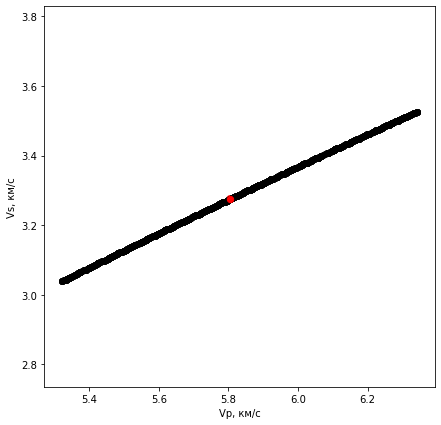

In [45]:
from time import time
import matplotlib.patches as patches

por_np = (np.random.randint(0, 200, size = N))/10
por = por_np.tolist()

vs = []
vp = []
good_por = []

fig = plt.figure(figsize = (7 ,7))
ax = fig.add_subplot(111)
circle = patches.Circle((vp_true, vs_true), allowable_error, facecolor='w', edgecolor = 'r')
ax.add_patch(circle)

start = time()
for i in range(len(por)):
    porosity = por[i]
    vp_sample, vs_sample = do_forward_problem_pores_fast(cal_dol_anh_ill, fluid, rho_matrix)
    
    check = check_how_close(vp_true, vs_true, vp_sample, vs_sample, allowable_error)
    ax.scatter(vp_sample, vs_sample, c = 'k')
    if check == True:
        vp.append(vp_sample)
        vs.append(vs_sample)
        good_por.append(por[i])

ax.scatter(vp_true, vs_true, c = 'r', s = 40)
ax.set_xlabel('Vp, км/c', fontsize = 10)
ax.set_ylabel('Vs, км/c', fontsize = 10)
ax.axis('equal')
fig.show()

avg_por = sum(good_por) / len(good_por)
    
end = time()

print(vp)
print(vs)

print(len(vp))
print(end - start)
print()
print(avg_por)
print(good_por)

## Добавление к (кальцит+доломит) ангидрита по HS 

In [21]:
# проделаем все те же шаги
anh_prop, anh_bulk_d, anh_bulk_u, anh_shear_d, anh_shear_u = get_HS_for_all_proportions(anhydrite, cal_dol)

anh_bulk_average = []
anh_shear_average = []
for i in range(len(anh_prop)):
    anh_bulk_average.append((anh_bulk_d[i] + anh_bulk_u[i])/2)
    anh_shear_average.append((anh_shear_d[i] + anh_shear_u[i])/2)
    
proportion = round(get_proportion_for_HS(anh_proportion, cal_dol_proportion))
print('содержание ангидрита в смеси кальцит+доломит+ангидрит:', proportion)
print('bulk modulus смеси (кальцит+доломит)+ангидрит:', anh_bulk_average[proportion])
print('shear modulus смеси (кальцит+доломит)+ангидрит:', anh_shear_average[proportion])

содержание ангидрита в смеси кальцит+доломит+ангидрит: 18
bulk modulus смеси (кальцит+доломит)+ангидрит: 71.53616043141696
shear modulus смеси (кальцит+доломит)+ангидрит: 36.11295446864736


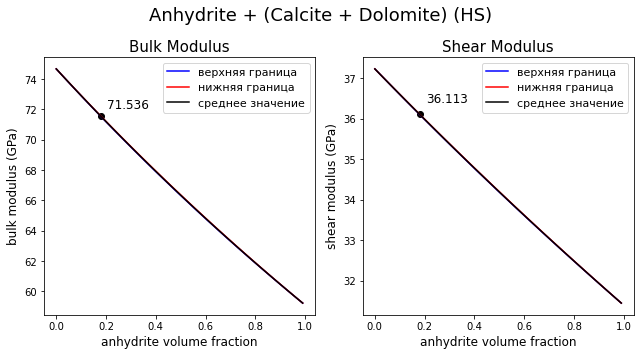

In [22]:
draw_HS_plots(proportion, anh_prop, anh_bulk_d, anh_bulk_u, anh_bulk_average,
                 anh_shear_d, anh_shear_u, anh_shear_average, title = 'Anhydrite + (Calcite + Dolomite) (HS)', 
                  xlabel = 'anhydrite volume fraction')

In [23]:
# подготовим данные смеси для дальнейших рассчетов
cal_dol_anh = [round(anh_bulk_average[proportion], 3), round(anh_shear_average[proportion], 3)]
cal_dol_anh_proportion = cal_proportion + dol_proportion + anh_proportion

print('упругие свойства смеси кальцит+доломит',cal_dol_anh)
print('объемное содержание смеси кальцит+доломит',cal_dol_anh_proportion)

упругие свойства смеси кальцит+доломит [71.536, 36.113]
объемное содержание смеси кальцит+доломит 85


## Добавление к смеси иллита 

### По Хашину-Штрикману 

In [24]:
ill_prop, ill_bulk_d, ill_bulk_u, ill_shear_d, ill_shear_u = get_HS_for_all_proportions(illite, cal_dol_anh)

ill_bulk_average = []
ill_shear_average = []
for i in range(len(ill_prop)):
    ill_bulk_average.append((ill_bulk_d[i] + ill_bulk_u[i])/2)
    ill_shear_average.append((ill_shear_d[i] + ill_shear_u[i])/2)
    
proportion = round(get_proportion_for_HS(ill_proportion, cal_dol_anh_proportion))
print('содержание иллита в смеси (кальцит+доломит+ангидрит) + иллит:', proportion)
print('bulk modulus смеси (кальцит+доломит+ангидрит) + иллит по HS:', ill_bulk_average[proportion])
print('shear modulus смеси (кальцит+доломит+ангидрит) + иллитпо HS:', ill_shear_average[proportion])

содержание иллита в смеси (кальцит+доломит+ангидрит) + иллит: 11
bulk modulus смеси (кальцит+доломит+ангидрит) + иллит по HS: 63.10984719197283
shear modulus смеси (кальцит+доломит+ангидрит) + иллитпо HS: 33.05492220506396


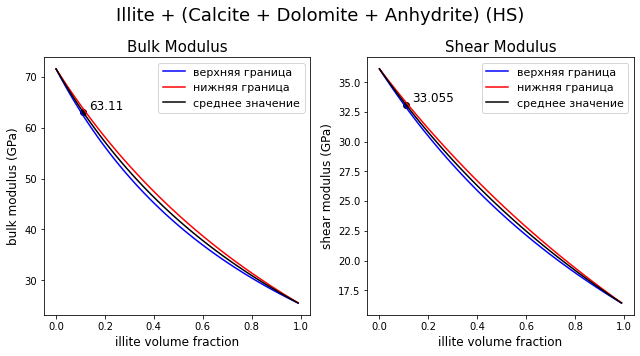

In [25]:
draw_HS_plots(proportion, ill_prop, ill_bulk_d, ill_bulk_u, ill_bulk_average,
                 ill_shear_d, ill_shear_u, ill_shear_average, title = 'Illite + (Calcite + Dolomite + Anhydrite) (HS)', 
                  xlabel = 'illite volume fraction')

### По SCA 

In [26]:
# в методе SCA необходимо учитывать также аспектные отношения, поэтому немного изменим данные
matrix = [cal_dol_anh[0], cal_dol_anh[1], 1]   # смесь кальцит+доломит+ангидрит с аспектным отношением 1
illite = [25.3, 16.3, 0.001]

In [27]:
por, bulk, shear = get_all_values_by_SCA(illite, matrix)

print('содержание иллита в смеси (кальцит+доломит+ангидрит) + иллит:', proportion)
print('bulk modulus смеси (кальцит+доломит+ангидрит) + иллит по SCA:', bulk[proportion])
print('shear modulus смеси (кальцит+доломит+ангидрит) + иллит: по SCA', shear[proportion])

содержание иллита в смеси (кальцит+доломит+ангидрит) + иллит: 11
bulk modulus смеси (кальцит+доломит+ангидрит) + иллит по SCA: 62.58559144875411
shear modulus смеси (кальцит+доломит+ангидрит) + иллит: по SCA 32.891722967880064


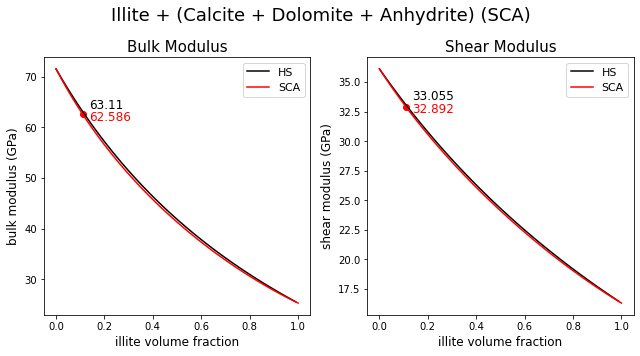

In [28]:
draw_HS_SCA_comparison_plots(por, bulk, shear, ill_prop, ill_bulk_average, ill_shear_average, proportion,
                                 xlabel = 'illite volume fraction', 
                                 title = 'Illite + (Calcite + Dolomite + Anhydrite) (SCA)')

In [29]:
# мы закончили смешивание твердых компонент
matrix_without_pores = [round(bulk[proportion], 3), round(shear[proportion], 3)]
print('упругие свойства твердой матрицы:', matrix_without_pores)

упругие свойства твердой матрицы: [62.586, 32.892]


## Добавление в твердую матрицу пор 

### Круглые поры по DEM 

In [30]:
por_dem, bulk_dem, shear_dem = get_all_values_by_DEM(matrix_without_pores)
por_hs, bulk_down, bulk_up, shear_down, shear_up = get_HS_for_all_proportions([0.01, 0.01], matrix_without_pores)

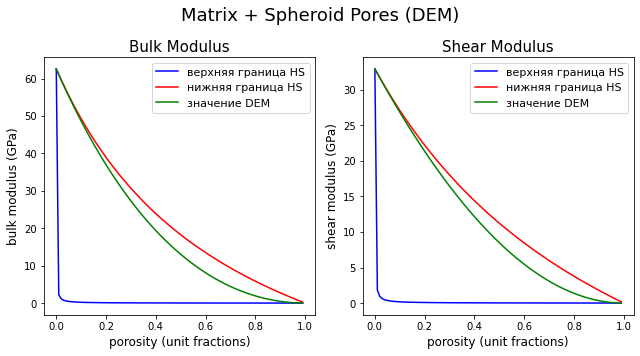

In [31]:
draw_DEM_plots(por_hs, bulk_down, bulk_up, shear_down, shear_up, por_dem, bulk_dem, shear_dem,
                 title = 'Matrix + Spheroid Pores (DEM)', xlabel = 'porosity (unit fractions)', legend_item = 'значение DEM')

In [32]:
print('объемное содержание круглых пор:', por_dem[4])
print('bulk modulus композита с 4% круглых пор:', bulk_dem[4])
print('shear modulus композита с 4% круглых пор:', shear_dem[4])

объемное содержание круглых пор: 0.04
bulk modulus композита с 4% круглых пор: 56.71482725965178
shear modulus композита с 4% круглых пор: 30.39529742919524


### Трещины по SCA 

In [33]:
matrix = [bulk_dem[4], shear_dem[4], 1]   # твердая матрица с круглыми порами с аспектным отношением 1
cracks = [0, 0, 0.01]

In [34]:
por_sca, bulk_sca, shear_sca = get_all_values_by_SCA(cracks, matrix)
por_hs, bulk_down, bulk_up, shear_down, shear_up = get_HS_for_all_proportions([0.01, 0.01], matrix)

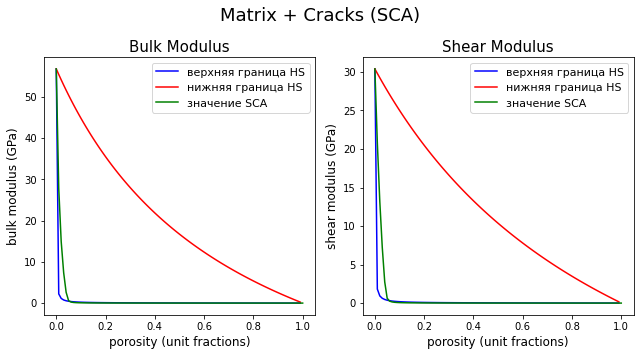

In [35]:
draw_DEM_plots(por_hs, bulk_down, bulk_up, shear_down, shear_up, por_sca, bulk_sca, shear_sca,
                 title = 'Matrix + Cracks (SCA)', xlabel = 'porosity (unit fractions)', legend_item = 'значение SCA')

In [36]:
print('объемное содержание круглых пор:', por_sca[1])
print('bulk modulus композита с 1% трещин:', bulk_sca[1])
print('shear modulus композита с 1% трещин:', shear_sca[1])

dry = [bulk_sca[1], shear_sca[1]]

объемное содержание круглых пор: 0.01
bulk modulus композита с 1% трещин: 27.78960584647303
shear modulus композита с 1% трещин: 20.788376245087075


# Wood & Gassmann Formulas

In [37]:
# bulk модуль смеси флюидов по формуле Вуда (prop - в процентах)
def get_fluid_modulus_by_wood(fluid1, fluid2, prop):
    # функция принимает на вход объемные модули сжатия и объемное содержание всех флюидов,
    # входящих в поронасыщающую смесь, и возвращает модуль сжатия смеси (модуль сдвига флюида всегда = 0)

    bulk = [fluid1[0], fluid2[0]]
    average_shear = 0
    
    if bulk[0] == 0:
        bulk[0] = 0.0000001
    if bulk[1] == 0:
        bulk[1] = 0.0000001

    bulk = np.array(bulk)
    prop = np.array(prop)

    new_prop = prop / 100   # объемные отношения в долях единицы
    divided_bulk = np.sum(new_prop / bulk)
    average_bulk = 1 / divided_bulk   # объемный модуль сжатия смеси флюидов

    return [average_bulk, average_shear]

In [38]:
# формула Гассмана - получаем упругие модули породы, поры которой насыщены флюидом
def get_saturated_by_gassman(dry, matrix, fluid, porosity):
    k_dry, g_dry = dry  # сухая порода
    k_m, g_m = matrix  # твердое вещество (без пор)
    k_fl, g_fl = fluid  # флюид

    g_sat = g_dry

    k_sat = k_dry + (1 - k_dry / k_m) ** 2 / (porosity / k_fl + (1 - porosity) / k_m - k_dry / k_m ** 2)

    return [k_sat, g_sat]

In [39]:
# рассчет скоростей vp и vs
def get_velocity(rho_components, proportions, saturated):
    
    rho = 0
    for i in range(len(rho_components)):
        rho += rho_components[i] * proportions[i] / 100
    
    k, g = saturated[0], saturated[1]
    
    vp = math.sqrt((k + g * 4/3) / rho)
    vs = math.sqrt(g / rho)
    return vp, vs

In [40]:
fluid = get_fluid_modulus_by_wood(water, gas, 50)
print('упругие модули флюида:', fluid)

упругие модули флюида: [0.08067481277098935, 0]


In [41]:
saturated = get_saturated_by_gassman(dry, matrix_without_pores, fluid, porosity)

print('bulk modulus финального композита:', saturated[0])
print('bulk modulus финального композита:', saturated[1])

bulk modulus финального композита: 27.794599057322902
bulk modulus финального композита: 20.788376245087075


In [42]:
rho_components = [2.71, 2.87, 2.97, 2.52, 0.13, 0.962]
proportions = [40, 30, 15, 10, 2.5, 2.5]

vp, vs = get_velocity(rho_components, proportions, saturated)

In [43]:
print('vp (км/с)', vp)
print('vs (км/с)', vs)

vp (км/с) 4.559904747881327
vs (км/с) 2.790428634430583
